<a href="https://colab.research.google.com/github/Spencer166/Second/blob/main/Step_8_Old.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 8: Scale Your ML Prototype

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from joblib import Memory

In [10]:
# Path to the dataset
file_path = "/content/drive/MyDrive/train.csv"

# Load into DataFrame
df_full = pd.read_csv(file_path)

# Sample 100,000 rows
df = df_full.sample(n=100000, random_state=1)

# Display first few rows
print(df.shape)
df.head()

(100000, 13)


,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
566215,566215,52233.83,0.125,663,7454.22,14.89,Female,Married,PhD,Employed,Education,D2,1.0
123502,123502,29247.24,0.127,639,20391.28,12.29,Male,Married,High School,Unemployed,Debt consolidation,D2,0.0
367747,367747,13802.88,0.164,736,17984.01,11.00,Male,Single,Bachelor's,Self-employed,Home,C5,1.0
359153,359153,48758.31,0.090,707,10209.48,10.17,Female,Married,Bachelor's,Employed,Debt consolidation,C2,1.0
440880,440880,49816.42,0.090,665,18123.14,16.06,Male,Single,High School,Employed,Debt consolidation,D4,1.0


In [11]:
# Check for missing values
df.isnull().sum()

,0
id,0
annual_income,0
debt_to_income_ratio,0
credit_score,0
loan_amount,0
interest_rate,0
gender,0
marital_status,0
education_level,0
employment_status,0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 566215 to 461415
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    100000 non-null  int64  
 1   annual_income         100000 non-null  float64
 2   debt_to_income_ratio  100000 non-null  float64
 3   credit_score          100000 non-null  int64  
 4   loan_amount           100000 non-null  float64
 5   interest_rate         100000 non-null  float64
 6   gender                100000 non-null  object 
 7   marital_status        100000 non-null  object 
 8   education_level       100000 non-null  object 
 9   employment_status     100000 non-null  object 
 10  loan_purpose          100000 non-null  object 
 11  grade_subgrade        100000 non-null  object 
 12  loan_paid_back        100000 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 10.7+ MB


In [13]:
#Check for duplicates
df.duplicated().sum()

np.int64(0)

In [14]:
# Summary statistics of the dataset
round(df.describe(),1)

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,loan_paid_back
count,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0,100000.0
mean,296937.3,48192.3,0.1,680.8,15008.6,12.4,0.8
std,171086.2,26770.9,0.1,55.4,6905.2,2.0,0.4
min,9.0,6098.4,0.0,435.0,507.5,4.0,0.0
25%,149877.0,27910.4,0.1,646.0,10275.3,11.0,1.0
50%,296187.0,46434.3,0.1,682.0,14986.1,12.4,1.0
75%,444985.8,60943.9,0.2,719.0,18852.0,13.7,1.0
max,593992.0,393064.0,0.6,849.0,48960.0,20.6,1.0


In [15]:
df["loan_paid_back"].value_counts(normalize=True)

,proportion
loan_paid_back,
1.0,0.79758
0.0,0.20242


In [16]:
# Define Target
target = "loan_paid_back"

# Split into features and Target
X = df.drop(columns=[target])
y = df[target]

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y)

# Separate numeric and categorical columns
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns


# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop="first",handle_unknown='ignore'), cat_cols)])

In [28]:
# Define models and parameter grids
models = {
    "Logistic Regression": (
        LogisticRegression(random_state=1, max_iter=500),
        {
            "model__C": [0.01, 0.1, 1, 10],
            "model__C": np.logspace(-4, 2, 50)}),

    "Random Forest": (
        RandomForestClassifier(random_state=1, n_jobs=-1),
        {
            "model__n_estimators": [100, 200],
            "model__max_depth": [None, 10, 20],
            "model__min_samples_split": [2, 5, 10]}),

    "Gradient Boosting": (
        GradientBoostingClassifier(random_state=1),
        {
            "model__max_depth": [4, 6, 8],
            "model__learning_rate": [0.03, 0.05, 0.1],
            "model__n_estimators": [100, 200]})}

In [29]:
from joblib import Memory
memory = Memory("cache_dir", verbose=0)

# Define results list
results = []

# Create for loop to interate over models and parameter grids
for name, (model, param_grid) in models.items():
    print(f"Tuning {name}...")

# Create pipeline
    pipe = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", model)])

# Create a grid search object
    rs = RandomizedSearchCV(
        pipe,
        param_distributions=param_grid,
        cv=3,
        n_iter=10,
        scoring="roc_auc",
        n_jobs=-1,
        random_state=1)

# Fit to the training data
    rs.fit(X_train, y_train)

# Append results to results list
    results.append({
        "Model": name,
        "Best ROC_AUC": rs.best_score_,
        "Best Params": rs.best_params_})

Tuning Logistic Regression...
Tuning Random Forest...


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
# Print table with Best ROC_AUC/Params for each model
pd.set_option('display.max_colwidth', None)
results_df = pd.DataFrame(results).sort_values(by="Best ROC_AUC", ascending=False).reset_index(drop=True)
results_df

,Model,Best ROC_AUC,Best Params
0,Gradient Boosting,0.890090,"{'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100}"
1,Logistic Regression,0.880225,"{'model__C': 0.1, 'model__penalty': 'l2'}"
2,Random Forest,0.877439,"{'model__max_depth': 10, 'model__min_samples_split': 5, 'model__n_estimators': 200}"


In [ ]:
# Identify best model and best parameters
best_model_name = results_df.iloc[0]["Model"]
best_params = results_df.iloc[0]["Best Params"]

# Define final model
final_model = models[best_model_name][0].set_params(**{
    k.replace("model__", ""): v for k, v in best_params.items()})

# Create final pipeline
final_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", final_model)])

# Fit to the full training data
final_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['age', 'annual_income', 'monthly_income', 'debt_to_income_ratio',
       'credit_score', 'loan_amount', 'interest_rate', 'loan_term',
       'installment', 'num_of_open_accounts', 'total_credit_limit',
       'current_balance', 'delinquency_history', 'public_records',
       'num_of_delinquencies'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  Index(['gender', 'marital_status', 'education_level', 'employment_status',
       'loan_purpose', 'grade_subgrade'],
      dtype='object'))])),
                ('model', GradientBoostingClassifier(random_state=1))])

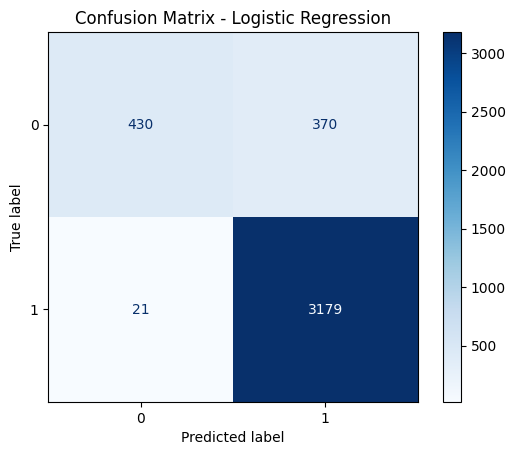

ROC-AUC: 0.9033589843750001
Accuracy: 0.90225

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.54      0.69       800
           1       0.90      0.99      0.94      3200

    accuracy                           0.90      4000
   macro avg       0.92      0.77      0.81      4000
weighted avg       0.91      0.90      0.89      4000



In [ ]:
# Define predictions and probabilities
y_pred = final_pipeline.predict(X_test)
y_prob = final_pipeline.predict_proba(X_test)[:, 1]

# Generate a confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# Define metrics
acc = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)
cm = confusion_matrix(y_test, y_pred)

# Print metrics
print("ROC-AUC:", roc)
print("Accuracy:", acc)
print("\nClassification Report:\n", classification_report(y_test, y_pred))